Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого.

<b>Цель исследования</b> - определить причины убытков и помочь компании выйти в плюс.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

<b>Описание данных:</b>

**Таблица visits_log_short** (лог сервера с информацией о посещениях сайта):

User Id — уникальный идентификатор пользователя
Device — категория устройства пользователя
Session start — дата и время начала сессии
Session End — дата и время окончания сессии
Channel — идентификатор рекламного источника, из которого пришел пользователь
Region - страна пользователя

**Таблица orders_log_short** (информация о заказах):

User Id — уникальный id пользователя, который сделал заказ
Event Dt — дата и время покупки
Revenue — выручка

**Таблица costs_short** (информация о затратах на маркетинг):

Channel — идентификатор рекламного источника
Dt — дата
Costs — затраты на этот рекламный источник в этот день

### Загрузите данные и подготовьте их к анализу, выполните предобработку

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math

import time
from datetime import datetime
from datetime import date, timedelta as td

In [2]:
#прочитаем и сохраним журналы визитов, заказов и расходов в переменные
visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info.csv')
costs = pd.read_csv('/datasets/costs_info.csv')  

In [3]:
#посмотрим данные о визитах
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


столбцы с датами представлены в виде строк, переведем их в формат дат

In [5]:
#преобразуем данные о времени
visits['Session Start'] = pd.to_datetime(visits['Session Start'], format="%d.%m.%Y %H:%M")
visits['Session End'] = pd.to_datetime(visits['Session End'], format="%d.%m.%Y %H:%M")

In [6]:
#проеобразуем данные о регионе, устройстве и канале трафика к формату строки
visits['Region'] = visits['Region'].astype(str)
visits['Device'] = visits['Device'].astype(str)
visits['Channel'] = visits['Channel'].astype(str)

In [7]:
#переименуем столбцы в нижний регистр
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [8]:
#преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

ознакомимся с данными:

In [9]:
visits['user_id'].value_counts()

33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

уникальных пользователей - 150008

In [10]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

пользователи представляют 4 страны -  США, Великобританию, Францию и Германию

In [11]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

пользователи заходят с 4 типов устройств - iPhone, Android, PC, Mac

In [12]:
visits['session_start'].count()

309901

In [13]:
visits['session_start'].value_counts()

2019-09-19 12:10:00    9
2019-07-09 10:59:00    8
2019-08-24 18:51:00    8
2019-10-06 18:08:00    8
2019-10-04 23:27:00    8
                      ..
2019-08-24 09:43:00    1
2019-06-17 09:33:00    1
2019-05-18 20:58:00    1
2019-09-02 08:43:00    1
2019-07-23 04:19:00    1
Name: session_start, Length: 180519, dtype: int64

всего записей о начале сессии - 309901, из них уникальные - 180519

In [14]:
visits['session_end'].count()

309901

In [15]:
visits['session_end'].value_counts()

2019-10-27 16:09:00    10
2019-10-04 12:55:00     9
2019-10-08 18:07:00     9
2019-07-05 19:29:00     8
2019-09-24 15:42:00     8
                       ..
2019-07-26 04:39:00     1
2019-06-26 16:04:00     1
2019-08-04 03:39:00     1
2019-08-22 01:39:00     1
2019-08-17 15:40:00     1
Name: session_end, Length: 180778, dtype: int64

всего записей об окончании сессии так же - 309901, из них уникальные - 180778

In [16]:
#проверим журнал визитов на явные дубликаты
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


явных дубликатов строк нет

In [17]:
#посмотрим данные о заказах
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [19]:
#преобразуем формат данных в столбце Event Dt во временной
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'], format="%Y-%m-%d %H:%M:%S")

In [20]:
#переименуем столбцы в нижний регистр
orders.columns = ['user_id', 'event_dt', 'revenue']

In [21]:
#преобразуем данные о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [22]:
orders['user_id'].value_counts()

901180916748    22
883098437811    20
75337957494     19
512471511263    19
295795879965    19
                ..
237296010927     1
319939546352     1
742075710598     1
202972423389     1
775233404832     1
Name: user_id, Length: 8881, dtype: int64

в логах о заказах - 8881 уникальный пользователь

In [23]:
orders['event_dt'].value_counts()

2019-09-29 09:03:24    2
2019-10-25 16:24:24    2
2019-09-27 03:56:55    2
2019-08-12 22:50:49    2
2019-09-09 20:01:39    2
                      ..
2019-09-26 04:24:10    1
2019-10-26 06:25:45    1
2019-07-10 17:04:38    1
2019-08-06 08:55:42    1
2019-09-25 16:41:33    1
Name: event_dt, Length: 40163, dtype: int64

In [24]:
orders['event_dt'].count()

40212

в логах о заказах 40212 строк о времени заказа, из них уникальные - 40163

In [25]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

средняя сумма заказа - 5.37, медиана и среднее не сильно отличаются друг от друга, поэтому можно предположить, что сильных выбросов нет. 4.99 может быть стоимостью подписки в приложении

In [26]:
#проверим журнал заказов на явные дубликаты
orders[orders.duplicated()]

,user_id,event_dt,revenue


явных дубликатов строк нет

In [27]:
#посмотрим на журнал расходов
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [28]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [29]:
#преобразуем данные о дате расходов
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [30]:
#приведем формат данных в столбце с идентификатором рекламного источника в формат строки
costs['Channel'] = costs['Channel'].astype('str')

In [31]:
#переименуем столбцы журнала в нижний регистр
costs.columns = ['dt', 'channel', 'costs']

In [32]:
costs['dt'].count()

1800

In [33]:
costs['dt'].value_counts()

2019-10-10    10
2019-06-01    10
2019-08-30    10
2019-10-14    10
2019-06-12    10
              ..
2019-05-24    10
2019-07-08    10
2019-08-22    10
2019-10-06    10
2019-08-26    10
Name: dt, Length: 180, dtype: int64

1800 строк с данными о расходах на рекламу, из них 180 - с уникальными датами совершения расходов, то есть данные о расходах представлены за 180 дней.

In [34]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

в данных содержится информация о 10 каналах рекламы - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds'

In [35]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Среднее значение и медиана расходов на рекламу сильно разнятся (58,6 и 12,3). По всей видимости есть небольшое количество очень дорогих рекламных кампаний, которые тянут среднее вверх. Дорогие эти рекламные кампаний либо из-за дороговизны самого канала, либо из-за высокого объема разовой закупки рекламы в рамках одной "дорогой" кампании. 

In [36]:
#проверим проверим журнал расходов на наличие явных дубликатов
costs[costs.duplicated()]

,dt,channel,costs


явных дубликатов строк нет

# Вывод 1

На первом этапе мы сохранили данные о визитах, заказах и рекламных расходах в переменные и подготовили их к анализу. Также было проверено, что в трех журналах отсутствуют явные дубликаты, а также что тип данных во всех колонках соответствует значениям.

Уникальных пользователей - 150008. Пользователь, который чаще всего заходит в приложение, имеет 46 посещений. В логах имеются данные о пользователях из 4х стран - США, Великобритании, Франции, Германии. Устройства, с которых заходят - iPhone, Android, PC, Mac. Чаще всего заходят с iPhone (112603). Всего 180519 уникальных записей с информацией о начале сессии и 180778 уникальных записей с информацией о конце сессии. Всего записей 309901.

В логах о заказах у нас присутствует 8881 уникальный пользователь, чаще всех заказывает пользователь с идентификационным номером 901180916748. В выгрузке 40212 строк с информацией о заказах. Из них 40163 с уникальным 'event_dt'. Средняя сумма заказа - 5.37. Медиана и среднее довольно близко расположены, можно предположить, что сильных выбрососв в данных нет. Также видно, что 1, 2, 3 и 4 квантили - все они равны 4.99. Можно предположить, что это стоимость подписки.

Всего 1800 строк с данными о затратах на маркетинг. Из них 180 уникальных записей с датами, то есть, в логах собраны данные за 180 дней. В выгрузке представлены данные по закупкам в 10 каналах - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds' Средние и медианные затраты на маркетинг разнятся (58.6 и 12.2 соответственно) - возможно, есть небольшое количество очень дорогих рекламных кампаний, которые тянут среднее вверх. Дорогие эти рекламные кампаний либо из-за дороговизны самого канала, либо из-за высокого объема разовой закупки рекламы в рамках одной такой кампании.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

зададим функции функции на 3, 4 и 5 шагах по факту необходимости применения функций

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [37]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

получим профили пользователей. Для этого вызовем функцию get_profiles, передав ей данные о посещениях

In [38]:
# получим профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


определим самую раннюю и позднюю даты привлечения пользователей

In [39]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

In [40]:
print(min_analysis_date, "\n", observation_date)

2019-05-01 00:00:00 
 2019-10-27 00:00:00


самая ранняя и поздняя даты совпадают с датами указанными в задании - 1 мая и 27 октября соответственно

построим таблицу, отражающую количество пользователей и их долю для каждой страны

In [41]:
share_by_region = pd.DataFrame()
share_by_region['users'] = profiles.groupby('region')['user_id'].count()
share_by_region['share'] = ((share_by_region['users'] / profiles['region'].count()) * 100)
share_by_region.sort_values(by='share', ascending=False)

,users,share
region,,
United States,100002,66.664445
UK,17575,11.716042
France,17450,11.632713
Germany,14981,9.986801


самая большая доля пользователей в разрезе стран - из США (67%), далее следуют почти с равными долями Великобритания и Франция (11.7% и 11.6%), наименьшая доля среди стран - у Германии (9.9%)

построим таблицу, отражающую количество платящих пользователей и их долю для каждой страны

In [42]:
payers_share_by_region = pd.DataFrame()
payers_share_by_region['users'] = profiles.query('payer == True').groupby('region')['user_id'].count()
payers_share_by_region['share'] = ((payers_share_by_region['users'] / profiles.query('payer == True')['region'].count()) * 100)
payers_share_by_region.sort_values(by='share', ascending=False)

,users,share
region,,
United States,6902,77.716473
UK,700,7.881995
France,663,7.465376
Germany,616,6.936156


самая большая доля платящих пользователей в разрезе стран у США (78%), Великобритания, Франция и Германия имеют примерно одинаковые, сильно меньшие, доли в 7-8% платящих пользователей от общего числа пользователей

найдем долю платящих для каждой страны

In [43]:
def pivot_share(column, df):
    result = pd.DataFrame()
    result['users'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users'] / df[column].count()) * 100)
    result['payers'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payers_share'] = ((result['payers'] / result['users']) * 100)
    return result.sort_values(by='payers_share', ascending=False)

In [44]:
pivot_share('region', profiles)

,users,users_share,payers,payers_share
region,,,,
United States,100002,66.664445,6902,6.901862
Germany,14981,9.986801,616,4.111875
UK,17575,11.716042,700,3.982930
France,17450,11.632713,663,3.799427


самая большая доля платящих пользователей относительно общего количества пользователей в стране у США - 6.9%, далее идет Германия - 4,1%, Великобритания - 4% и Франция - 3,8%

узнаем доли пользователей в разрезе устройств

In [45]:
share_by_device = pd.DataFrame()
share_by_device['users'] = profiles.groupby('device')['user_id'].count()
share_by_device['share'] = ((share_by_device['users'] / profiles['device'].count()) * 100)
share_by_device.sort_values(by='share', ascending=False)

,users,share
device,,
iPhone,54479,36.317396
Android,35032,23.353421
PC,30455,20.302251
Mac,30042,20.026932


пользователи с iPhone составляют наибольшую долю среди пользователей в разрезе устройств - 36%, далее идут пользователи с Android - 23%. Доли пользователей, заходящих через PC и Mac примерно одинаковые - 20%

узнаем доли платящих пользователей в разрезе устройств

In [46]:
payers_share_by_device = pd.DataFrame()
payers_share_by_device['users'] = profiles.query('payer == True').groupby('device')['user_id'].count()
payers_share_by_device['share'] = ((payers_share_by_device['users'] / profiles.query('payer == True')['device'].count()) * 100)
payers_share_by_device.sort_values(by='share', ascending=False)

,users,share
device,,
iPhone,3382,38.081297
Android,2050,23.082986
Mac,1912,21.529107
PC,1537,17.306610


пользователи с iPhone составляют наибольшую долю среди платящих пользователей в разрезе устройств - 38%, далее идут владельцы Android - 23%, Mac - 22% и PC - 17%

узнаем доли платящих пользователей в разрезе устройств

In [47]:
pivot_share('device', profiles)

,users,users_share,payers,payers_share
device,,,,
Mac,30042,20.026932,1912,6.364423
iPhone,54479,36.317396,3382,6.207897
Android,35032,23.353421,2050,5.851793
PC,30455,20.302251,1537,5.046790


наибольшая доля платящих пользователей в разрезе устройств у Mac - 6.36%: 1912 человек из 30042 платят за продукт. Среди владельцев iPhone доля платящих равна 6.21%: 3382 из 54479 готовы платить в приложении. Для пользователей Android доля платящих составляет 5.85% (2050 из 35032), для пользователей PC - 5.05% (1537 из 30455)

посмотрим на источники привлечения и определим каналы, посредством которых пришло больше всего платящих пользователей

In [48]:
share_by_channel = pd.DataFrame()
share_by_channel['users'] = profiles.groupby('channel')['user_id'].count()
share_by_channel['share'] = ((share_by_channel['users'] / profiles['channel'].count()) * 100)

share_by_channel['payers'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
share_by_channel['payers_share'] = ((share_by_channel['payers'] / profiles.query('payer == True')['channel'].count()) * 100)

share_by_channel.sort_values(by='share', ascending=False)

,users,share,payers,payers_share
channel,,,,
organic,56439,37.623993,1160,13.061592
FaceBoom,29144,19.428297,3557,40.051796
TipTop,19561,13.039971,1878,21.146267
OppleCreativeMedia,8605,5.736361,233,2.623578
LeapBob,8553,5.701696,262,2.950118
WahooNetBanner,8553,5.701696,453,5.100777
RocketSuperAds,4448,2.965175,352,3.963518
MediaTornado,4364,2.909178,156,1.756559
YRabbit,4312,2.874513,165,1.857899


наибольшая доля привлеченных пользователей приходится на органический трафик (38%), далее по доле привлечения идут FaceBoom и TipTop - 19% и 13% соответственно, доли по остальным каналам варьируются от 1% до 6%

наибольшая доля привлеченных платящих пользователей также приходится на FaceBoom - 40%, далее идут TipTop - 21% и органический трафик - 13%, доли по остальным каналам варьируются от 1% до 5%

узнаем доли платящих пользователей в разрезе каналов привлечения

In [49]:
pivot_share('channel', profiles)

,users,users_share,payers,payers_share
channel,,,,
FaceBoom,29144,19.428297,3557,12.204914
AdNonSense,3880,2.586529,440,11.340206
lambdaMediaAds,2149,1.432590,225,10.469986
TipTop,19561,13.039971,1878,9.600736
RocketSuperAds,4448,2.965175,352,7.913669
WahooNetBanner,8553,5.701696,453,5.296387
YRabbit,4312,2.874513,165,3.826531
MediaTornado,4364,2.909178,156,3.574702
LeapBob,8553,5.701696,262,3.063253


наибольшие доли платящих пользователей от общего числа пользователей привлеченных каналом у таких источников трафика, как: FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%)

наименьшая доля платяющих пользователей в разрезе каналов привлечения у органического трафика - 2%

# Вывод 2

На втором этапе мы сформировали профили пользователей, определили начальную и конечную даты привлечения пользователей.

Построена таблица, отражающая количество пользователей и их долю из каждой страны. Cамая большая доля пользователей - из США (67%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%).

Изучены платящие пользователи и их доля из каждой страны. Платящие пользователи из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%) Доля платящих пользователей в США - 6.90%. Среди пользователей из Англии (17575) платящий сегмент составляет 3.98% (700 человек). Примерно такое же соотношение и для пользователей из Франции (3.80% платящих пользователей). Среди пользователей Германии (14981 человека) 616 человек - платящие (4.1%).

Определено, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи. Владельцы IPhone и Android составляют 36% и 23% соответственно. Клиенты чаще пользуются мобильными устройствами, чем персональными компьютерами. Доли PC и Mac практически одинаковы - по 20%.

Набольшая доля платящих пользователей - у Mac: 6.36% (1912 человек) из 30042 платят за продукт. Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%. Среди пользователей PC (30455) платящих меньше всего - 5.05% (1537 человек).

Определены источники привлечения и каналы, из которых пришло больше всего платящих пользователей. Судя по разбивке в разрезе источников привлечения для всех пользователей (и платящих, и неплатящих), наибольшая доля приходится на органический трафик (38%), далее по числу пользователей идут FaceBoom (19%) и TipTop(13%).

Лучше всего пользователи конвертируются в платящих в таких каналах привлечения, как FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%). Худшая конвертация в платящих приходится на органический трафик - 2%.





### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

посчитаем общую сумму расходов на маркетинг

In [50]:
display(costs.sum())

channel    FaceBoomFaceBoomFaceBoomFaceBoomFaceBoomFaceBo...
costs                                               105497.3
dtype: object

всего на маркетинг потрачено 105497

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__


Расчёт верный

In [51]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


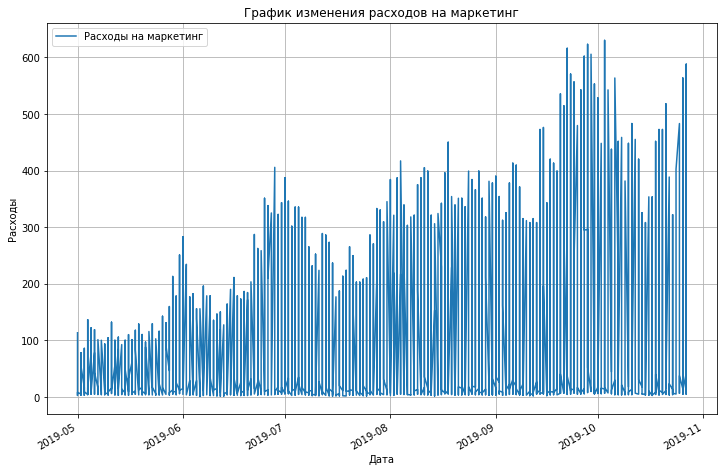

In [52]:
costs.plot(y='costs', 
           x='dt',
           figsize=(12, 8), 
           grid=True,        
           label='Расходы на маркетинг',                       
           legend=True
          ) 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

со временем расходы на маркетинг увеличивались. Пик расходов пришелся на начало октября, затем был спад, к концу октября расходы опять приблизились к пиковым показателям

In [53]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [54]:
costs_by_channel = pd.DataFrame()
costs_by_channel['costs'] = costs.groupby('channel')['costs'].sum()
costs_by_channel['share'] = ((costs_by_channel['costs'] / costs['costs'].sum()) * 100)
costs_by_channel.sort_values(by='share', ascending=False)

,costs,share
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


больше всего маркетинговых расходов приходится на источник TipTop - более 50%, также заметная доля от общего обхема расходов приходится на источник Faceboom - 30%. Доли других источников заметно ниже и колеблются от 1% до 5%

In [55]:
costs['month'] = costs['dt'].dt.month
filtered_data_by_month = costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
    )

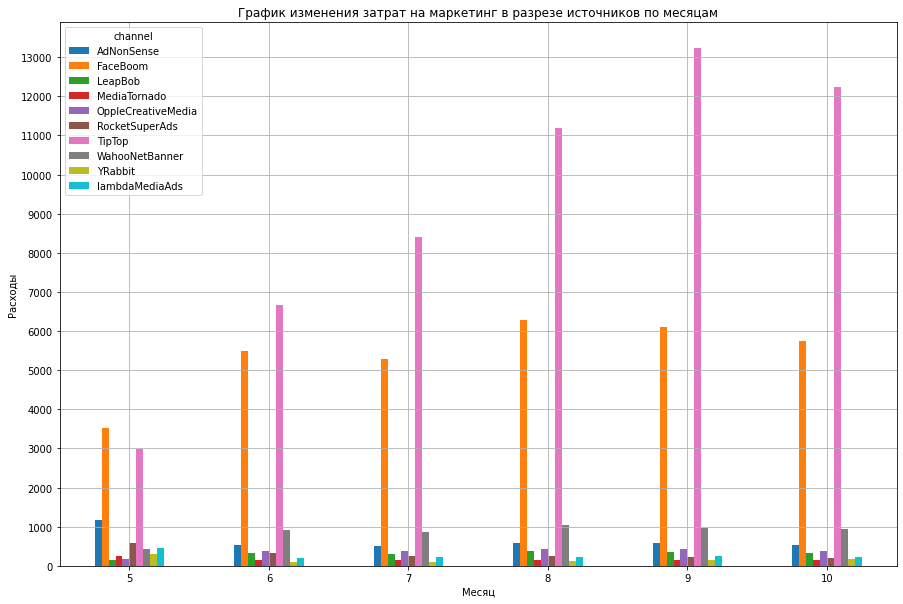

In [56]:
filtered_data_by_month.plot(
           kind='bar',
           figsize=(15, 10), 
           grid=True,        
           label='Источники',                   
           legend=True,
) 

plt.yticks(np.arange(0, 14000, 1000)) 
plt.title('График изменения затрат на маркетинг в разрезе источников по месяцам')
plt.xlabel('Месяц')
plt.xticks(rotation='horizontal') 
plt.ylabel('Расходы')
plt.show()

график подтверждает, что больше всего маркетинговых расходов приходятся на источники TipTop и Faceboom. Ниже построим укрупненный график для всех иных источников.

In [57]:
filtered_data_by_month2 = costs[~costs['channel'].isin(['FaceBoom','TipTop'])].pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
    )

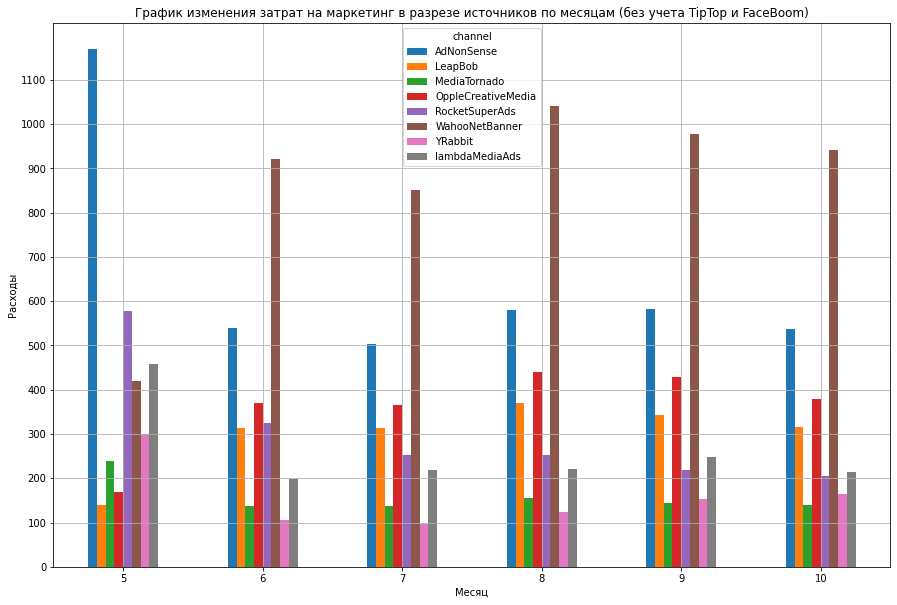

In [58]:
filtered_data_by_month2.plot(
           kind='bar',
           figsize=(15, 10), 
           grid=True,        
           label='Источники',                   
           legend=True,
) 

plt.yticks(np.arange(0, 1200, 100)) 
plt.title('График изменения затрат на маркетинг в разрезе источников по месяцам (без учета TipTop и FaceBoom)')
plt.xlabel('Месяц')
plt.xticks(rotation='horizontal') 
plt.ylabel('Расходы')
plt.show()

из графика видно, что третье место среди каналов по расходам за месяц в мае было у AdNonSense. С июня расходы на рекламу через данный канал заметно снизились, а на канал WahooNetBanner заметно выросли. С июня по октябрь WahooNetBanner стабильно 3-й по ррекламным расходам.

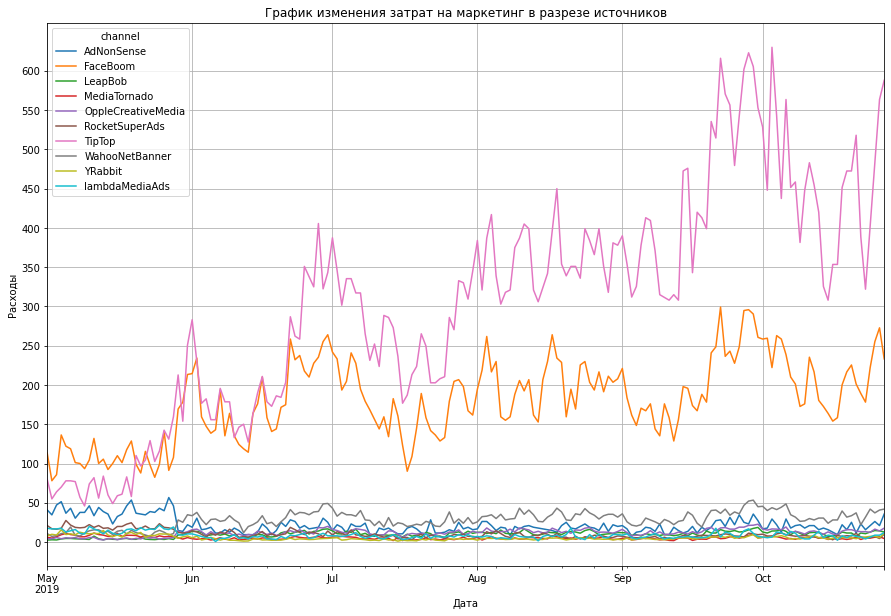

In [59]:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(15, 10), 
           grid=True,        
           label='Источники',                   
           legend=True,
) 

plt.yticks(np.arange(0, 650, 50)) 
plt.title('График изменения затрат на маркетинг в разрезе источников')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

график подтверждает вывод о том, что 2 самых заметных поставщиках трафика - это TipTop и FaceBoom. Расходы на привлечение через TipTop росли со времением до начала октября, в то время как расходы на FaceBoom почти на всем протяжении периода анализа варьировались от 150 до 300 

т.к. графики расходов на источники привлечения отличные от TipTop и FaceBoom слились на графике выше, построим для них отдельный график

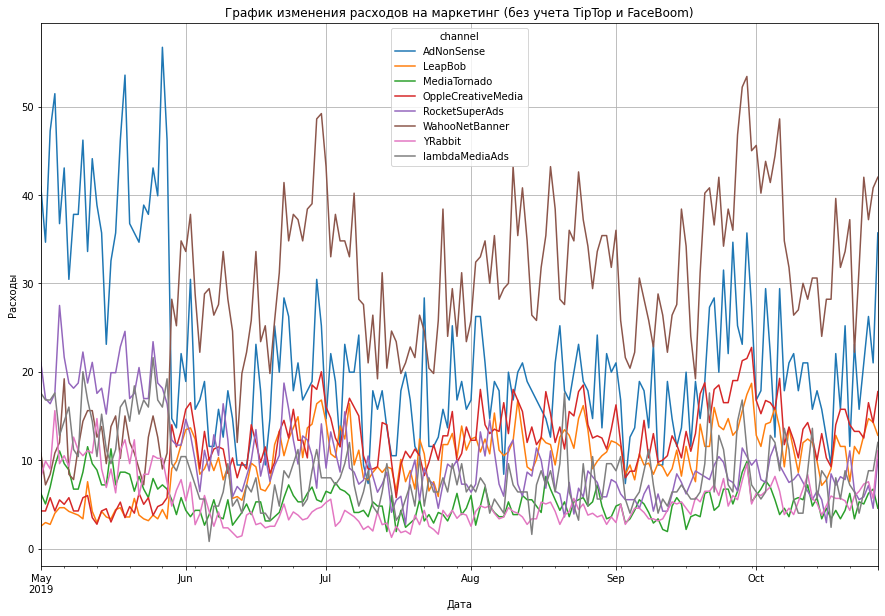

In [60]:
filtered_data2 = costs[~costs['channel'].isin(['FaceBoom','TipTop'])].pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data2.plot(                                             
           figsize=(15, 10),
           grid=True,       
           label='Источники',                      
           legend=True
) 

plt.yticks(np.arange(0,  60, 10)) 
plt.title('График изменения расходов на маркетинг (без учета TipTop и FaceBoom)')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

из графика видно, что расходы на источник AdNonSence с течением времени снижались после пика (примерно 50) в июне, в то время как расходы на источник lambdaMediaAds росли с течением времени с пиком (примерно 50) в октябре. Расходы на другие источники на всем протяжении периода анализа не превышали показатель в 20 за исключением пика расходов на источник OppleCreativeMedia в октябре (примерно 23)

In [61]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [62]:
profiles['acquisition_cost'].describe()

count    150008.000000
mean          0.703278
std           0.954097
min           0.000000
25%           0.000000
50%           0.247500
75%           1.108943
max           3.715385
Name: acquisition_cost, dtype: float64

медианная стоимость привлечения одного пользователя - 0.24, при этом среднее значение равно 0.7. Максимальная стоимость привлечения пользователя - 3.71

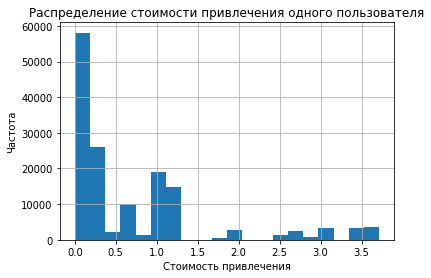

In [63]:
#посмотрим на распределение стоимости привленчения одного пользователя
profiles['acquisition_cost'].hist(bins=20)
plt.title('Распределение стоимости привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

In [64]:
#Посмотрим на CAC для каждого источника трафика
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False)

,acquisition_cost_mean
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


самый дорог трафик приходится на канал TipTop, средняя стоимость привлечения 2.8. Далее следуют FaceBoom и AdNonSense, средняя стоимость привлечения пользователя - 1. Средняя стоимость привлечения пользователя через другие каналы ниже 1

In [65]:
profiles_paying = profiles.query('channel != "organic"')
profiles_paying['acquisition_cost'].mean()

1.1274813239427588

cac без учета органического трафика составляет 1.13

# Вывод 3

Всего на маркетинг потрачено 105497.

Выяснено, что со временем расходы на маркетинг увеличивались. Пик расходов пришелся на начало октября, затем был спад, к концу октября расходы опять приблизились к пиковым показателям.

Мы выявили, как траты распределены по источникам. больше всего маркетинговых расходов приходится на источник TipTop - более 50%, также заметная доля от общего обхема расходов приходится на источник Faceboom - 30%. Доли других источников заметно ниже и колеблются от 1% до 5%.

Визуализировано, как расходы на маркетинг менялись в разрезе каналов привлечения трафика. Расходы на привлечение через TipTop росли со времением до начала октября, в то время как расходы на FaceBoom почти на всем протяжении периода анализа варьировались от 150 до 300. Расходы на источник AdNonSence с течением времени снижались после пика (примерно 50) в июне, в то время как расходы на источник lambdaMediaAds росли с течением времени с пиком (примерно 50) в октябре. Расходы на другие источники на всем протяжении периода анализа не превышали показатель в 20 за исключением пика расходов на источник OppleCreativeMedia в октябре (примерно 23). По остальным источникам совокупные траты варьировались в пределах 3-20.

Выяснено, что медианная стоимость привлечения одного пользователя - 0.24, при этом среднее значение равно 0.7. Максимальная стоимость привлечения пользователя - 3.71

Рассчитан средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Медианная стоимость привлечения одного пользователя - 0.24. При этом среднее находится на значении 0.7. Максимальная стоимость привлечения пользователя - 3.71.

На разницу между медианой и средним оказывает влияние большое число пользователей, привлеченных по нулевойн стоимости, т.е. органический трафик.

Самый дорогой трафик - TipTop (средняя стоимость - 2.8 за пользователя), далее идет FaceBoom и AdNonSense примерно в равной ценовой категории - в среднем 1 за пользователя. Остальные каналы берут за пользователя ниже 1.

Для всей рекламной кампании CAC без учета органического трафика составил 1.13.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [66]:
#зададим момент анализа и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

In [67]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

In [68]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [69]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [70]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [71]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [72]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [73]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [74]:
#исключим пользователей с органическим трафиком
profiles = profiles.query('channel != "organic"')

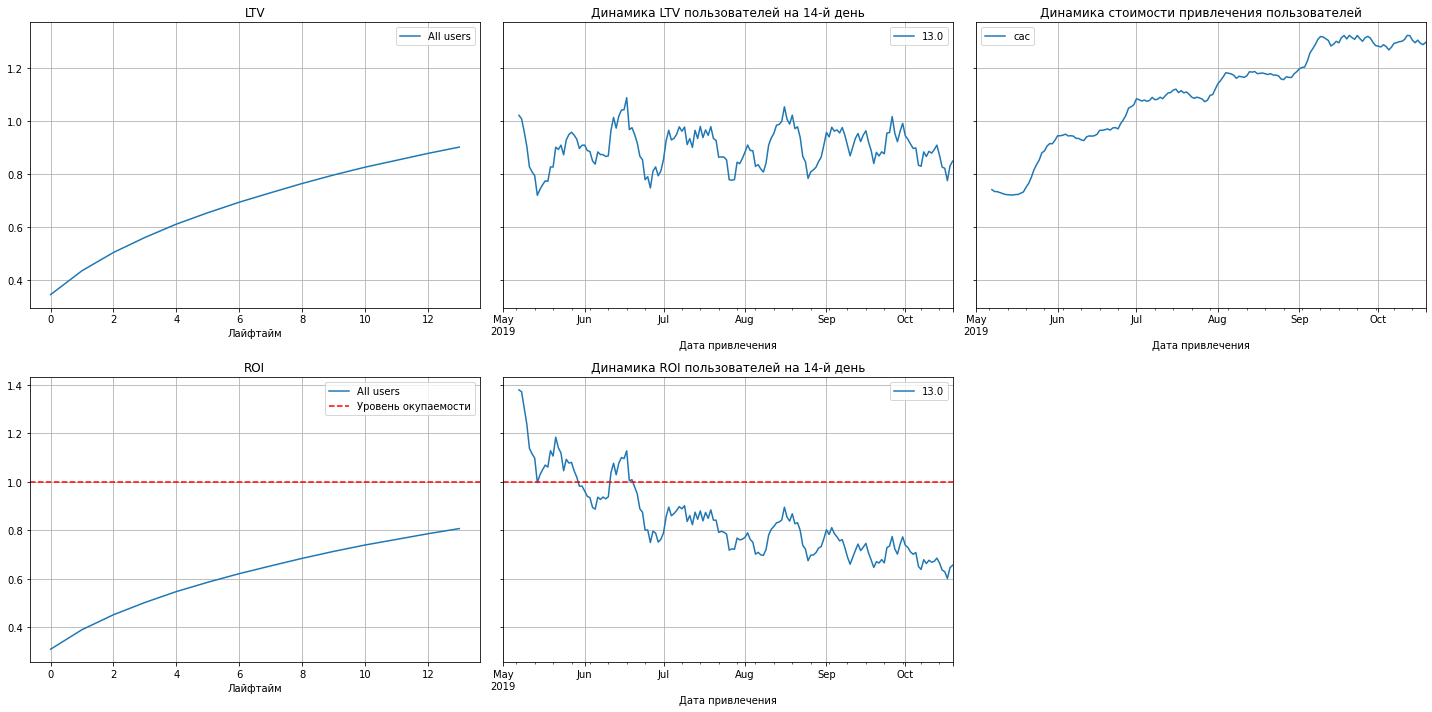

In [75]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Исходя из графиков можно сделать следующие выводы:
    
1. К концу второй ннедели расходы на рекламу все еще не окупаются, ROI на 12-й день составляет 80%.
2. Показатель CAC растет с течением времени, растет рекламный бюджет.
3. Показатель LTV растет, качество пользователей не ухудшается.
4. ROI пользователей на 14-й день падает с мая, в июне временами падал ниже 1, с июля показатель держится ниже 1, в октябре на уровне 0.6.

чтобы понять причины падения показателей, изучим характеристики пользователей - страну, источник привлечения, устройство

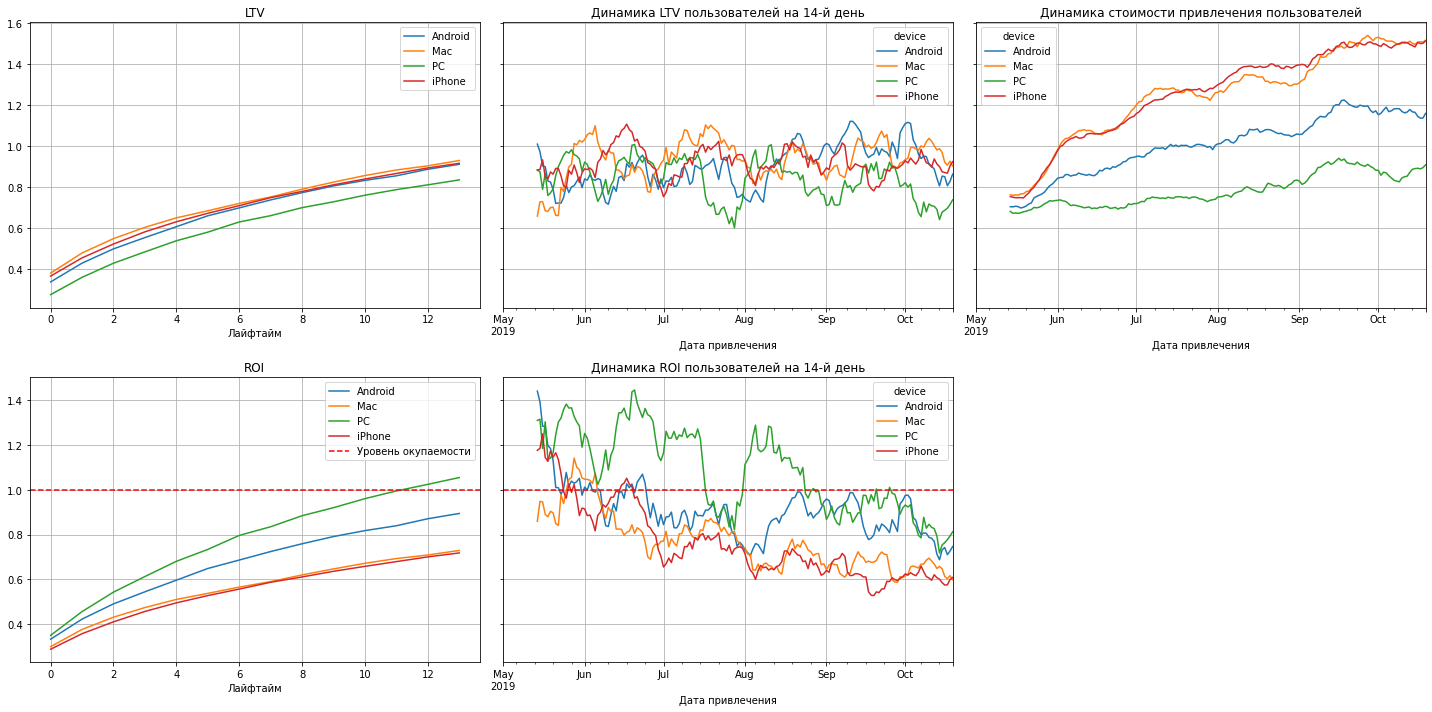

In [76]:
#посмотрим окупаемость в разрезе устройств
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Исходя из графиков можно сделать следующие выводы:

1. К концу второй недели расходы на рекламу окупаются только для пользователей PC, реклама для пользователей других устройств не окупается к концу второй недели.
2. Показатель CAC растет с течением времени для пользователей всех устройств. Самая высокая стоимость привлечения у пользователей iPhone и Mac.
3. Показатель LTV растет для всех устройств, качество пользователей не ухудшается ни для одного из устройств.
4. Начиная с июля ROI на 14-й дня ниже 1 для всех устройств кроме PC. Показатель для PC временами превышал 1 в июле и августе, но с сентября также не превышал 1, как и для других устройств.
5. Наиболее проблемные устройства с точки зрения окупаемости рекламы - iPhone и Mac: CAC для этих устройств самый высокий (около 1.5), а ROI на 14-й день самый низкий (около 60% в октябре).

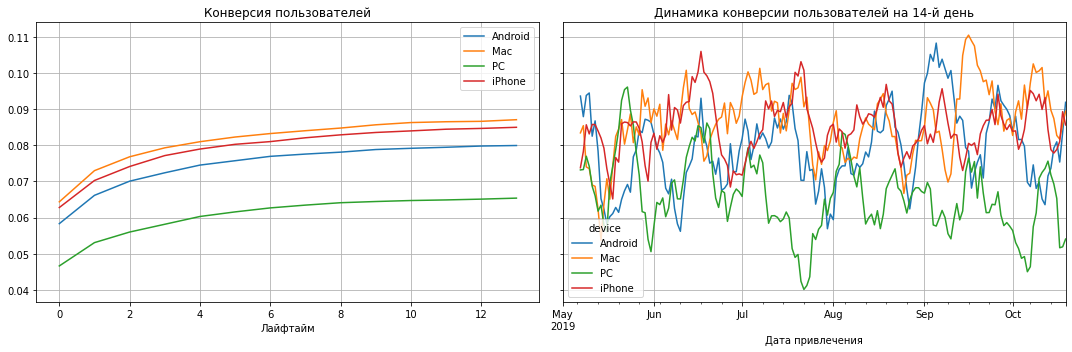

In [77]:
#посмотрим конверсию в разрезе устройств
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

в разрезе устройств хуже всего в платящих конвертируются пользователи PC

In [78]:
visits['visit_day'] = visits['session_start'].dt.date
visits['visit_day'] = pd.to_datetime(visits['visit_day'], format="%Y-%m-%d")

In [79]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

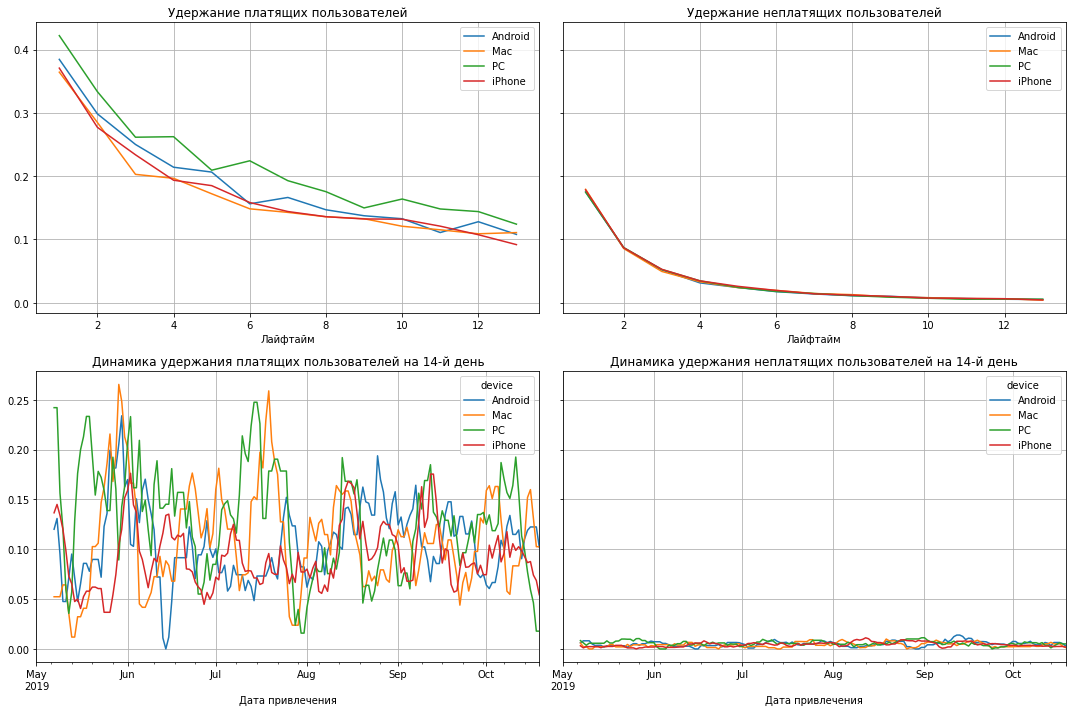

In [80]:
#посмотрим на удержание в разрезе устройств
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Из графиков можно сделать следующие выводы:

1. Неплатящие пользователи удерживаются стабильно плохо на всех устройствах.
2. Лучше всех удержание платящих пользователей просиходит на PC.

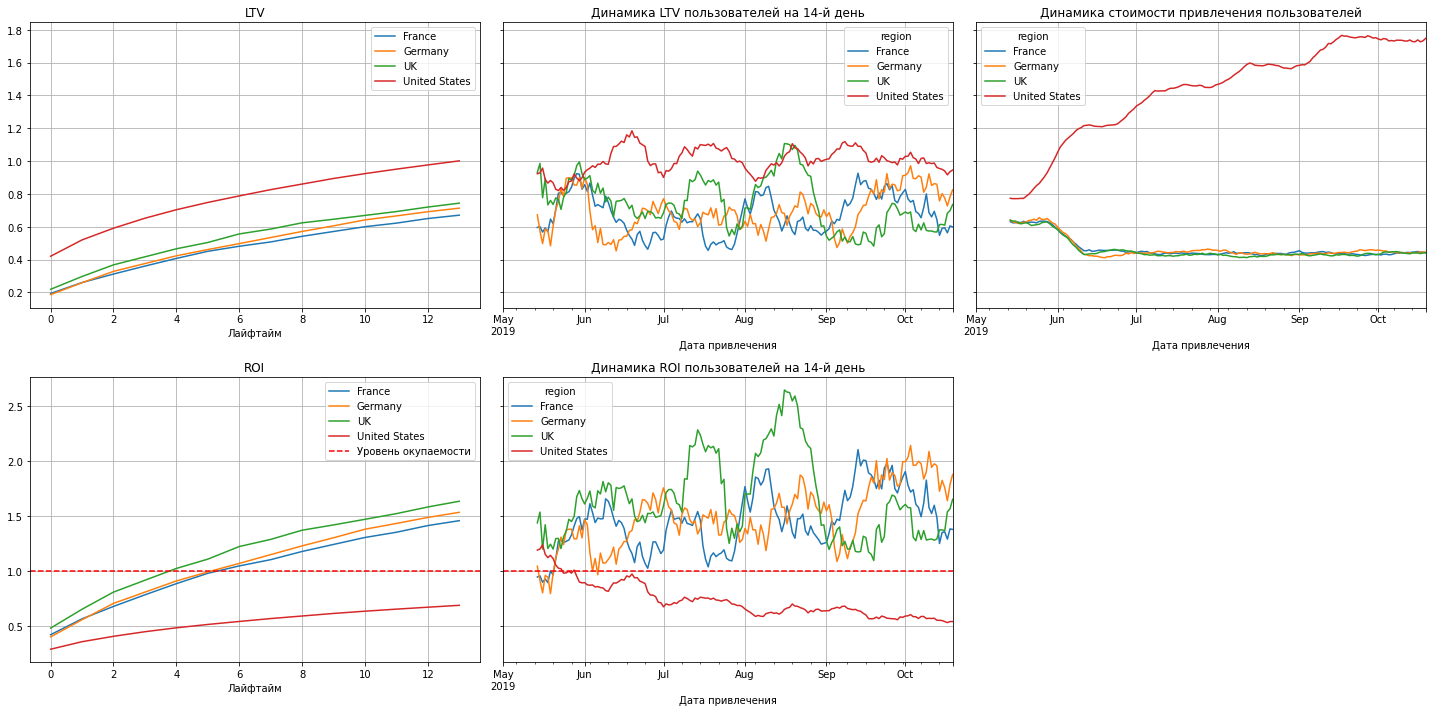

In [81]:
#посмотрим окупаемость в разрезе страны пользователей
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков можно сделать следующие выводы:

1. По итогам 14 дней расходы на рекламу окупаются во всех странах кроме США, при этом бОльшая часть пользователей приложения из США - 67%. У остальных стран ROI по итогам 14 дней примерно на одном уровне в 1.5.
2. Стоимость привлечения одного пользователя в США в разы выше, чем в других странах, при этом она продолжала расти до октября.
3. Как итог, самая проблемная страна - США.

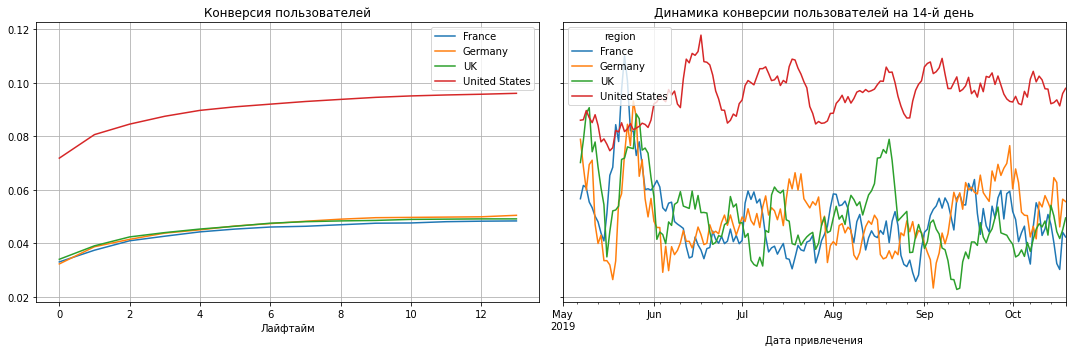

In [82]:
#посмотрим конверсию в разрезе стран

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

лучшая конверсия пользователей в платящих в США, в остальных странах показатель заметно ниже

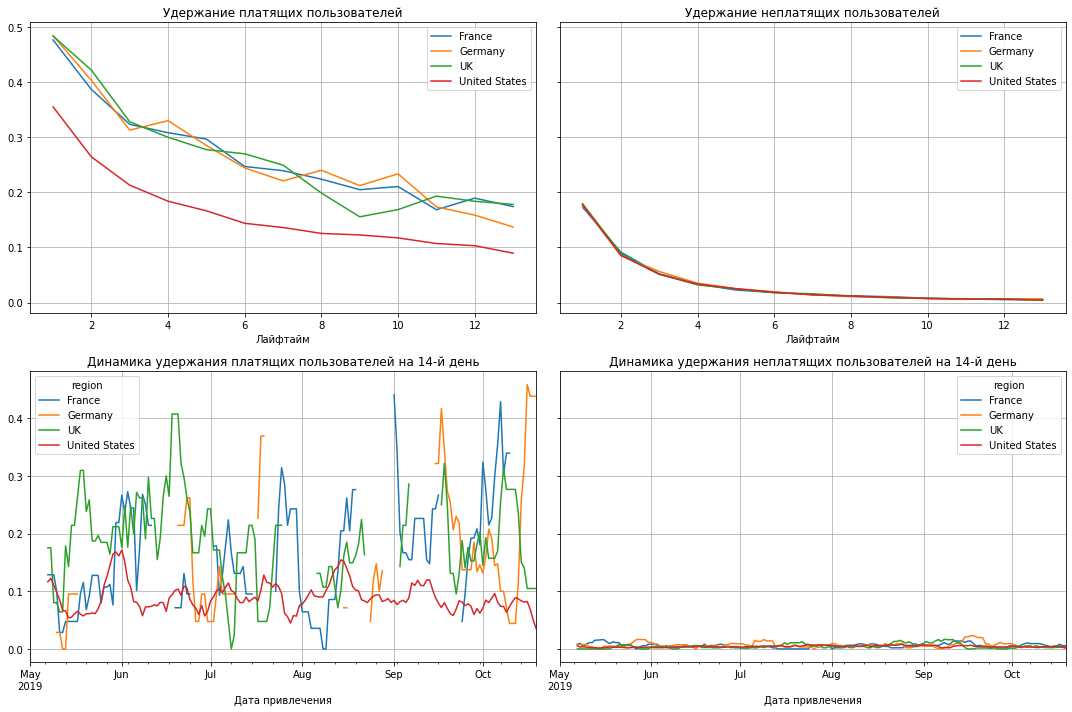

In [83]:
#посмотрим удержание в разрезе стран

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

главный вывод из графиков - пользователи из США удерживаются хуже всего

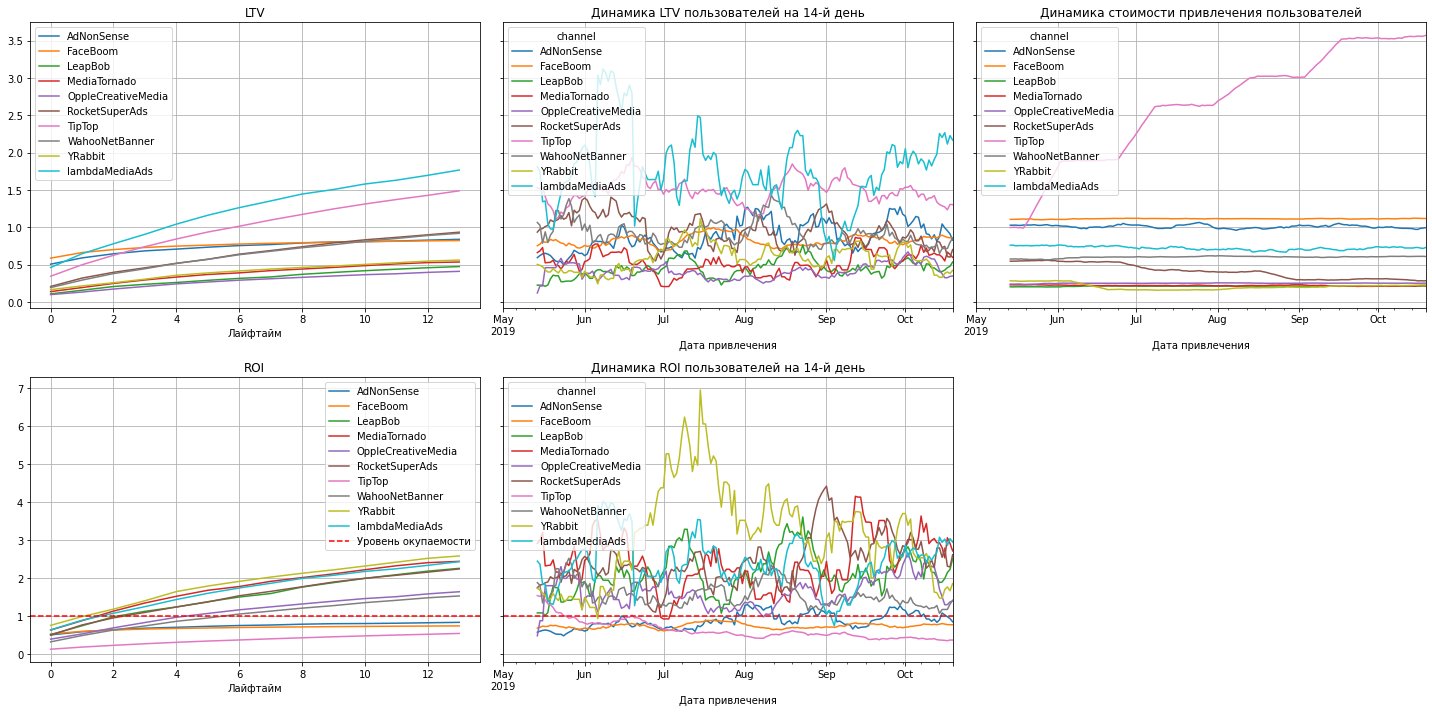

In [84]:
#посмотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков можно сделать следующие выводы:

1. За 14 дней не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop. Пользователи из остальных источников окупаются.
2.Лучший показатель ROI у канала YRabbit. Этот же канал достигал лучшего показателя ROI за 14 дней в период с мая по октябрь, а именно в июле с показателем 7.
3. Самая высокая стоимость привлечения у канала TipTop, при этом она всегда росла все время, начиная с мая. Но такие высокие затраты за 14 дней не окупаются.

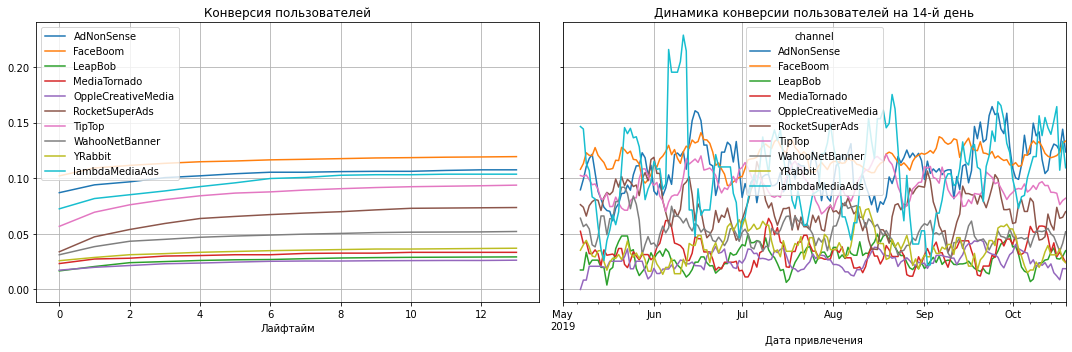

In [85]:
#посмотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

лучше всех в платящих конвертируются пользователи, пришедшие из канала FaceBoom

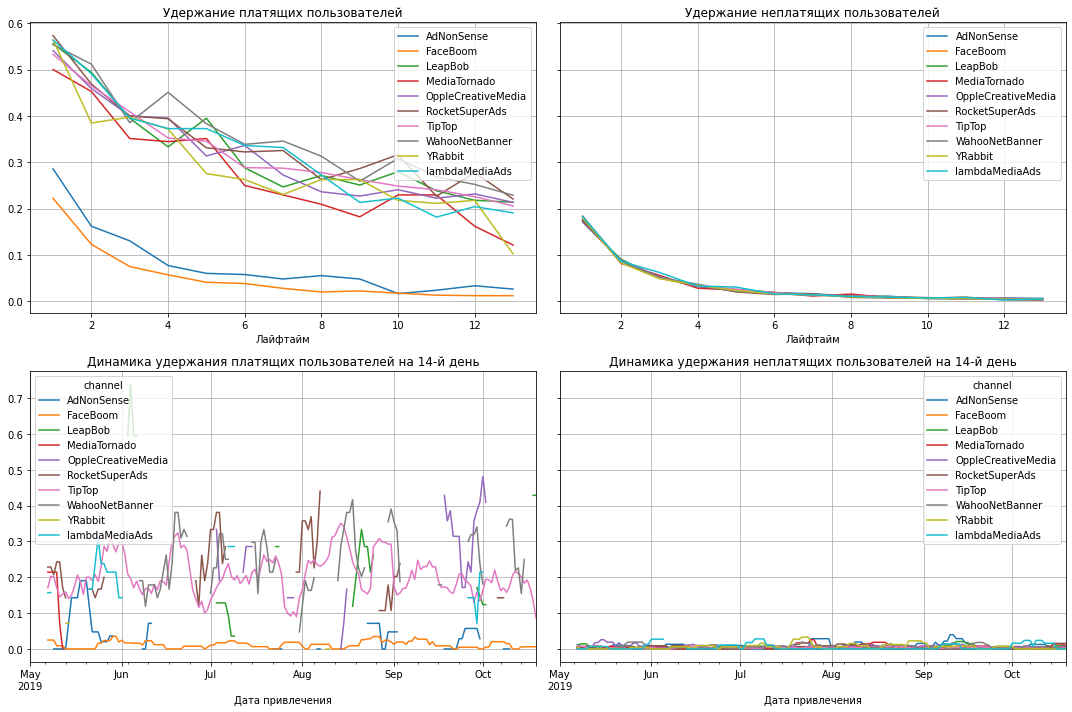

In [86]:
#посмотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

главный вывод из графиков - хуже всех удерживаются пользователи, привлеченные из каналов FaceBoom и AdNonSense

# Вывод 4

1. В целом, реклама близка к окупемости, но на горизонте в 14 дней все же не окупается, ROI — примерно 80%.
2. Общую окупаемость снижают владельцы Mac и iPhone (в совокупности на них приходится 56% пользователей в разрезе устройств), а также пользователи из США (доля 67% от общего числа пользователей в разрезе стран). Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop (в совокупности - 38% от общего числа пользователей в разрезе каналов привлечения).
3. Возможно, для окупаемости рекламы выбран недостаточный временный горизонт. 

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

По итогам исследования была оценена окупаемость рекламы по ряду показателей. Исходя из построенных графиков были сделаны следующие выводы:

1. Реклама не окупается к концу 2й недели. ROI — около 80%.
2. CAC нестабилен - постоянно растет.
3. ROI пользователей по итогам 14-дневных отрезков стабильно падает с мая. И если в начале июля реклама еще окупалась на 14-дневном отрезке, с начала июля реклама никогда не окупалась по итогам 14 дней. К концу ноября показатель составлял 0.6.

Для идентификации причин негативных показателей, упомянутых выше, были проанализированы характеристики пользователей, а именно - устройство, страна и канал привлечения.

1. В разрезе устройств:

С конца августа реклама не окупается для пользователей всех устройств.

Наиболее проблемными устройствами с точки зрения окупаемости являются Mac и iPhone, CAC у этих устройств заметно выше, чем у других. Реклама для пользователей с этих устройств на 14-дневном отрезке не окупается с июня, в октябре ROI для этих устройств составлял около 0.6.

Совокупная доля пользователей Mac и iPhone - 56%.

2. В разрезе стран.

На 14-дневном отрезке реклама не окупается только для пользователей из США. Для пользователей из США самый высокий, при этом постоянно растущий, CAC. На 14-дневном отрезке рекламные расходы в США не окупались ни разу с мая, при этом для других стран данные расходы окупались постоянно. В октябре ROI для пользователей США составил 0.5.

При этом доля пользователей из США от общего количества пользователей приложения - 67%. Из-за такой выосокой доли даже работающая в плюс реклама в других странах не может дать положительную совокупную отдачу.

3. В разрезе каналов привлечения.

За 14 дней рекламные расходы не окупаются только для пользователей, привлеченных из каналов LeapBop, FaceBoom, TipTop. При этом у TipTop самый высокий (в несколько раз по сравнению с другими источниками) и постоянно растущий CAC. 

Совокупная доля данных источников - 38% от общего числа пользователей в разрезе каналов привлечения.

# Рекомендации

Исходя из выделенных причин убытков можно дать следующие рекомендации для отдела маркетинга:
1. Необходимо обратить внимание на пользователей Mac и iPhone, возможно стоит провести определенные маркетинговые мероприятия для повышения LTV пользователей данных устройств. Если повысить LTV нет для данных устройств нет возможности, а затраты на рекламу для устройств останутся такими же высокими и возраставющими, возможно, имеет смысл каким-то образом перебалансировать доли пользователей с данными устройствами и пользователей с другими устройствами.
2. Необходимо обратить внимание на пользователей из США. Стоимость привлечения в США самая высокая и возрастающая, поэтому необходимо либо повышать LTV пользователей из США, либо диверсифицировать пользователей по странам, так как на такую проблемную с точки зрения окупаемости рекралмы страну приходится слишком высокая доля от общего числа пользователей. Лучше всего реклама окупается в Англии и Германии, возможно, стоит направить больше рекламных ресурсов на эти страны.
3. Необходимо сделать выводы по поводу привлечения трафика из каналов LeapBop, FaceBoom, TipTop. Реклама для TipTop самая дорогая, на TipTop и FaceBoom приходятся самые большие траты на рекламу по состоянию на октябрь. Скорее всего, стоит перенаправить ресурсы на более дешевые, но прибыльные каналы привлечения, например, YRabbit.